In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [2]:
from numba import vectorize, float64, guvectorize, jit

In [3]:
np.random.seed(6898)

## LOAD DATASET

In [4]:
# GENERATE DATA FROM STABLE DISTRI
@jit(nopython=True)
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    V = np.pi / 2 * (2 * np.random.rand(num_datasets, dataset_size) - 1)
    W = - np.log(np.random.rand(num_datasets, dataset_size))
    #r = np.zeros(n)

    if alpha != 1:
        const = beta * np.tan(np.pi * alpha / 2)
        b = math.atan(const)
        s = (1 + const * const)**(1 / (2 * alpha))
        r = s * np.sin(alpha * V + b) / ((np.cos(V)) ** (1/alpha)) * (( np.cos( (1-alpha) * V - b ) / W )**((1-alpha)/alpha))
        r = gamma * r + delta
    else:
        piover2 = np.pi / 2
        sclshftV = piover2 + beta * V
        r = 1/piover2 * (sclshftV * np.tan(V) - beta * np.log( (piover2 * W * np.cos(V) ) / sclshftV ))
        r = gamma * r + (2 / np.pi) * beta * gamma * np.log(gamma) + delta
    return r

In [5]:
actual_data = alpha_stable(1.5, 0.5, 1, 0, 200, 1)
actual_data

array([[ 1.31681746e+00, -5.59690263e-01, -2.20744774e+00,
         4.10324131e+00,  6.32944573e-01, -1.45400086e+00,
         3.72303782e+00,  1.38900571e-01,  2.23156567e+00,
         2.73309278e+00, -2.71194729e+00, -2.52262528e-02,
         2.03900212e+00, -4.22829139e-01, -9.25227458e-01,
        -4.64937818e+00, -3.44950504e-01, -1.64024439e+00,
         4.26236404e+00, -3.83393775e-01, -3.13020628e-02,
         7.38159748e+00, -1.83475091e+00,  6.09310644e-01,
        -3.94012712e-01,  1.12999045e+00, -2.07887081e+00,
        -1.10970425e+00,  2.86857435e+00, -1.42693689e+00,
        -1.56976650e+00, -2.48085584e+00,  3.00384195e+00,
        -1.16813926e-01, -7.09921540e-01, -1.62988768e+00,
        -1.36118864e+00, -2.20159179e+00,  2.08318703e+00,
        -1.57772976e+00,  6.82017825e+00,  8.75802454e-01,
        -2.56914833e-01, -4.11628733e-02,  1.79398899e+00,
         3.22292405e-01, -1.06704470e+00, -1.56794817e+00,
        -2.93534237e+00,  2.67588290e+00, -4.51305896e+0

In [6]:
# CALCULATE SUMMARY STATS
@jit
def alpha_stable_ss(data: np.ndarray) -> np.ndarray:
  # Compute quantile statistics
  v_stability = (np.percentile(data, 95) - np.percentile(data, 5)) / (np.percentile(data, 75) - np.percentile(data, 25))
  v_skewness = (np.percentile(data, 95) + np.percentile(data, 5) - 2 * np.percentile(data, 50)) / (np.percentile(data, 95) - np.percentile(data, 5))
  v_scale = (np.percentile(data, 75) - np.percentile(data, 25)) / 1
  v_loc = np.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = np.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = np.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = np.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = np.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = np.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = np.array([[0.0,    0.0,    0.0,    0.0,  0.0],  
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = max(np.append(0, np.argwhere(tv_stability <= v_stability)))
  tv_stability_i2 = min(np.append(14, np.argwhere(tv_stability >= v_stability)))
  tv_skewness_i1 = max(np.append(0, np.argwhere(tv_skewness <= abs(v_skewness))))
  tv_skewness_i2 = min(np.append(6, np.argwhere(tv_skewness >= abs(v_skewness))))
  dist_stability = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]
  if dist_stability != 0:
    dist_stability = (v_stability - tv_stability[tv_stability_i1]) / dist_stability

  dist_skewness = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = np.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = max(np.append(0, np.argwhere(t_stability >= alpha)))
  t_stability_i2 = min(np.append(15, np.argwhere(t_stability <= alpha)))
  t_skewness_i1 = max(np.append(0, np.argwhere(t_skewness <= abs(beta))))
  t_skewness_i2 = min(np.append(4, np.argwhere(t_skewness >= abs(beta))))

  dist_stability = t_stability[t_stability_i2] - t_stability[t_stability_i1]
  if dist_stability != 0:
    dist_stability = (alpha - t_stability[t_stability_i1]) / dist_stability

  dist_skewness = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = np.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + np.percentile(data, 50)

  if abs(alpha-1) < 0.05:
    mu = zeta
  else:
    mu = zeta - beta * sigma * math.tan(0.5 * math.pi *alpha)

  return np.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

# actual_summary_statistics = alpha_stable_ss(actual_data)
# actual_summary_statistics

In [7]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([ 1.55095344,  0.49840352,  1.0648519 , -0.00380977])

In [32]:
# Using previously simulated data for consistency
actual_summary_statistics = np.array([ 1.36495524,  0.27388675,  0.78684313, -0.08169088])

In [33]:
num_coeffs = np.shape(actual_summary_statistics)[0]
num_latent = np.shape(actual_summary_statistics)[0]
num_datasets = 100
n_samples = 200
gamma_samples = 20

In [28]:
gamma = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
theta = np.array([1.5,0.5,1,0])
theta_ = np.tile(theta, (gamma_samples, 1))
theta_
adjusted_theta = np.concatenate((theta_, gamma), axis = 1)
adjusted_theta[1, 0:4]

array([1.5, 0.5, 1. , 0. ])

In [34]:
@jit
def summary_statistics(theta, n_samples, n_datasets):
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
    n_summary_statistics = np.array([alpha_stable_ss(datasets[i,:]) for i in range(n_datasets)])
    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

@jit
def variance_adjustment_summary_statistics(adjusted_theta):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, n_samples, num_datasets)
    adjusted_sample_variance = sample_variance + np.diag(np.diag(sample_variance) * (Gamma ** 2))
    return sample_mean, adjusted_sample_variance

In [35]:
@jit
def prior(theta): 
    log_prior = multivariate_normal.logpdf(theta, cov= 10 * np.identity(num_coeffs))
    return log_prior

@jit
def unbiased_log_likelihood(theta):
    sample_mean = summary_statistics(theta, n_samples, num_datasets)[0]
    sample_variance = summary_statistics(theta, n_samples, num_datasets)[1]
    diff_mean_s = actual_summary_statistics - sample_mean
    part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1
    return u_est_log_likelihood

@jit
def variance_adjustment_unbiased_log_likelihood(gs_adjusted_theta):
    va_unbiased_log_likelihood = []
    for i in range(gamma_samples):
        sample_mean = variance_adjustment_summary_statistics(gs_adjusted_theta[i])[0]
        adjusted_sample_variance = variance_adjustment_summary_statistics(adjusted_theta[i])[1]
        diff_mean_s = actual_summary_statistics - sample_mean
        part1 = diff_mean_s.T @ np.linalg.inv(adjusted_sample_variance) @ diff_mean_s
        va_u_est_log_likelihood = -1/2 * np.log(np.linalg.det(adjusted_sample_variance)) - part1
        va_unbiased_log_likelihood.append(va_u_est_log_likelihood)
    return np.mean(va_unbiased_log_likelihood)

In [31]:
variance_adjustment_unbiased_log_likelihood(adjusted_theta)

1.7761344193149953

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [36]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 100 # number of datasets
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (self.num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(self.num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1.1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (np.exp(theta_tilde_0[1]) - 1) / (np.exp(theta_tilde_0[1]) + 1)
                    gamma_0 = np.exp(theta_tilde_0[2])
                    delta_0 = theta_tilde_0[3]
                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])

                    # GENERATE GAMMA
                    Gamma_init = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
                    adjusted_theta_0 = np.concatenate((np.tile(theta_0, (gamma_samples, 1)), Gamma_init), axis = 1)
                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) +  variance_adjustment_unbiased_log_likelihood(adjusted_theta_0) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1.1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (np.exp(theta_tilde_q[1]) - 1) / (np.exp(theta_tilde_q[1]) + 1)
                    gamma_q = np.exp(theta_tilde_q[2])
                    delta_q = theta_tilde_q[3]
                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])

                    # GENERATE GAMMA
                    Gamma = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
                    adjusted_theta_q = np.concatenate((np.tile(theta_q, (gamma_samples, 1)), Gamma), axis = 1)
                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + variance_adjustment_unbiased_log_likelihood(adjusted_theta_q) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [37]:
# Set hyperparameters
stop = 5000

In [38]:
vb = GVB(400, actual_summary_statistics, 0.02, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]/var/folders/d8/x9hvzkp5207f80bh52n_f4rw0000gn/T/ipykernel_14817/1355538749.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "prior" failed type inference due to: Untyped global name 'multivariate_normal': Cannot determine Numba type of <class 'scipy.stats._multivariate.multivariate_normal_gen'>

File "../../../../../var/folders/d8/x9hvzkp5207f80bh52n_f4rw0000gn/T/ipykernel_14817/1355538749.py", line 3:
<source missing, REPL/exec in use?>

  @jit
/anaconda3/envs/myenv/lib/python3.7/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "prior" was compiled in object mode without forceobj=True.

File "../../../../../var/folders/d8/x9hvzkp5207f80bh52n_f4rw0000gn/T/ipykernel_14817/1355538749.py", line 1:
<source missing, REPL/exec in use?>

  state.func_ir.loc))
/anaconda3/envs/myenv/lib/python3.7/site-packages/numba/core/object_mode_passes.py:162: NumbaDeprecationWarning: 

LB -11.873904898333196


  0%|          | 2/5000 [08:33<348:38:16, 251.12s/it]

LB -11.88745518312558


  0%|          | 3/5000 [12:57<356:50:51, 257.08s/it]

LB -11.120691742097343


  0%|          | 4/5000 [16:33<334:29:58, 241.03s/it]

LB -9.998924983588106


  0%|          | 5/5000 [20:36<335:08:24, 241.54s/it]

LB -9.691128627675791


  0%|          | 6/5000 [24:33<333:16:37, 240.25s/it]

LB -9.179661459829397


  0%|          | 7/5000 [28:30<331:22:30, 238.92s/it]

LB -8.76463576104462


  0%|          | 8/5000 [32:28<331:11:20, 238.84s/it]

LB -8.484053281910228


  0%|          | 9/5000 [36:26<330:32:22, 238.42s/it]

LB -8.008296212823124


  0%|          | 10/5000 [40:23<330:04:54, 238.14s/it]

LB -7.832881020157409


  0%|          | 11/5000 [44:21<329:51:54, 238.03s/it]

LB -7.790201987158823


  0%|          | 12/5000 [48:20<330:06:01, 238.24s/it]

LB -7.66700644821364


  0%|          | 13/5000 [52:16<329:10:58, 237.63s/it]

LB -7.710726512188505


  0%|          | 14/5000 [56:14<329:10:32, 237.67s/it]

LB -7.558527014468038


  0%|          | 15/5000 [1:00:24<334:14:01, 241.37s/it]

LB -7.841155345722197


  0%|          | 16/5000 [1:04:21<332:29:36, 240.16s/it]

LB -7.671084199653244


  0%|          | 17/5000 [1:08:19<331:31:21, 239.51s/it]

LB -7.6622985634125484


  0%|          | 18/5000 [1:12:21<332:32:19, 240.29s/it]

LB -7.6153497712735705


  0%|          | 19/5000 [1:16:18<331:09:54, 239.35s/it]

LB -7.677530219931925


  0%|          | 20/5000 [1:20:24<333:48:24, 241.31s/it]

LB -7.775461528364751


  0%|          | 21/5000 [1:24:17<330:18:33, 238.83s/it]

LB -7.758319629404605


  0%|          | 22/5000 [1:28:15<329:37:17, 238.38s/it]

LB -7.801542969027798


  0%|          | 23/5000 [1:33:11<353:38:24, 255.80s/it]

LB -7.82783018774607


  0%|          | 24/5000 [1:37:41<359:37:05, 260.17s/it]

LB -7.772615299343378


  0%|          | 25/5000 [1:41:58<357:55:34, 259.00s/it]

LB -7.500346107523769


  1%|          | 26/5000 [1:46:16<357:46:43, 258.95s/it]

LB -7.579613992641806


  1%|          | 27/5000 [1:50:33<356:34:49, 258.13s/it]

LB -7.657915657067013


  1%|          | 28/5000 [1:54:40<351:52:09, 254.77s/it]

LB -7.590425919412282


  1%|          | 29/5000 [1:58:48<349:06:00, 252.82s/it]

LB -7.539054086514377


  1%|          | 30/5000 [2:03:05<350:59:51, 254.24s/it]

LB -7.343182079802161


  1%|          | 31/5000 [2:07:32<355:51:23, 257.82s/it]

LB -7.3168253519578865


  1%|          | 32/5000 [2:11:48<355:01:19, 257.26s/it]

LB -7.302035925255414


  1%|          | 33/5000 [2:16:03<354:09:52, 256.69s/it]

LB -7.182433480060431


  1%|          | 34/5000 [2:19:53<343:06:56, 248.73s/it]

LB -7.3734390284198446


  1%|          | 35/5000 [2:23:48<337:18:44, 244.58s/it]

LB -7.135208495073789


  1%|          | 36/5000 [2:27:57<339:13:52, 246.02s/it]

LB -7.090295317891327


  1%|          | 37/5000 [2:32:44<355:52:39, 258.14s/it]

LB -7.06658591177132


  1%|          | 38/5000 [2:37:37<370:21:35, 268.70s/it]

LB -7.14799535743414


  1%|          | 39/5000 [2:42:34<381:54:14, 277.13s/it]

LB -7.1708682671204125


  1%|          | 40/5000 [2:47:06<379:36:53, 275.53s/it]

LB -7.193054382774514


  1%|          | 41/5000 [2:51:29<374:25:17, 271.81s/it]

LB -7.19832281199695


  1%|          | 42/5000 [2:55:59<373:45:49, 271.39s/it]

LB -7.190855090869601


  1%|          | 43/5000 [3:01:02<386:45:53, 280.89s/it]

LB -7.176274924095778


  1%|          | 44/5000 [3:05:57<392:34:15, 285.16s/it]

LB -7.128121738723556


  1%|          | 45/5000 [3:10:13<380:26:00, 276.40s/it]

LB -7.059131201468084


  1%|          | 46/5000 [3:14:17<366:36:02, 266.40s/it]

LB -7.267339264254577


  1%|          | 47/5000 [3:18:20<357:13:36, 259.64s/it]

LB -7.142649614851299


  1%|          | 48/5000 [3:22:22<349:33:06, 254.12s/it]

LB -7.162840494292998


  1%|          | 49/5000 [3:26:07<337:25:55, 245.36s/it]

LB -7.118038300808581


  1%|          | 50/5000 [3:29:35<322:17:03, 234.39s/it]

LB -6.992206298863064


  1%|          | 51/5000 [3:33:05<311:55:10, 226.90s/it]

LB Smoothed -7.790253817328687


  1%|          | 52/5000 [3:36:32<303:55:34, 221.13s/it]

LB Smoothed -7.693169148422013


  1%|          | 53/5000 [3:40:00<298:15:20, 217.04s/it]

LB Smoothed -7.611430487942515


  1%|          | 54/5000 [3:43:28<294:28:05, 214.33s/it]

LB Smoothed -7.553096891416734


  1%|          | 55/5000 [3:46:55<291:32:54, 212.25s/it]

LB Smoothed -7.502045229792959


  1%|          | 56/5000 [3:50:23<289:33:42, 210.85s/it]

LB Smoothed -7.460906390052218


  1%|          | 57/5000 [3:53:51<288:30:58, 210.13s/it]

LB Smoothed -7.429348658323519


  1%|          | 58/5000 [3:57:19<287:22:24, 209.34s/it]

LB Smoothed -7.400819807002796


  1%|          | 59/5000 [4:23:01<836:18:14, 609.33s/it]

LB Smoothed -7.385570087373602


  1%|          | 60/5000 [4:27:31<696:19:37, 507.44s/it]

LB Smoothed -7.376072377223303


  1%|          | 61/5000 [4:32:00<597:47:54, 435.73s/it]

LB Smoothed -7.3654605123914205


  1%|          | 62/5000 [4:36:22<526:24:07, 383.77s/it]

LB Smoothed -7.355568774993012


  1%|▏         | 63/5000 [4:40:49<478:22:35, 348.83s/it]

LB Smoothed -7.344923775913074


  1%|▏         | 64/5000 [4:45:12<442:52:43, 323.01s/it]

LB Smoothed -7.339501164182305


  1%|▏         | 65/5000 [4:49:37<418:43:32, 305.45s/it]

LB Smoothed -7.3267694987880745


  1%|▏         | 66/5000 [4:54:02<402:08:27, 293.41s/it]

LB Smoothed -7.314845939610924


  1%|▏         | 67/5000 [4:58:30<391:31:57, 285.73s/it]

LB Smoothed -7.306336063113498


  1%|▏         | 68/5000 [5:02:53<382:22:20, 279.10s/it]

LB Smoothed -7.299235965716657


  1%|▏         | 69/5000 [5:07:17<375:43:55, 274.31s/it]

LB Smoothed -7.290769848874634


  1%|▏         | 70/5000 [5:11:46<373:48:30, 272.96s/it]

LB Smoothed -7.277552320142643


  1%|▏         | 71/5000 [5:16:14<371:28:22, 271.31s/it]

LB Smoothed -7.26878828902685


  1%|▏         | 72/5000 [5:20:52<374:05:26, 273.28s/it]

LB Smoothed -7.257574478945419


  1%|▏         | 73/5000 [5:25:16<370:12:45, 270.50s/it]

LB Smoothed -7.244760466321963


  1%|▏         | 74/5000 [5:29:44<369:21:02, 269.93s/it]

LB Smoothed -7.2329784659031295


  2%|▏         | 75/5000 [5:34:10<367:32:08, 268.66s/it]

LB Smoothed -7.2263640744710225


  2%|▏         | 76/5000 [5:38:38<367:02:12, 268.35s/it]

LB Smoothed -7.218639098260319


  2%|▏         | 77/5000 [5:43:07<367:25:35, 268.68s/it]

LB Smoothed -7.211450221960749


  2%|▏         | 78/5000 [5:47:35<366:49:54, 268.30s/it]

LB Smoothed -7.205544328324005


  2%|▏         | 79/5000 [5:52:02<366:15:41, 267.94s/it]

LB Smoothed -7.201388585445508


  2%|▏         | 80/5000 [5:56:24<363:52:31, 266.25s/it]

LB Smoothed -7.202385562303275


  2%|▏         | 81/5000 [6:00:53<364:55:53, 267.08s/it]

LB Smoothed -7.20265759233033


  2%|▏         | 82/5000 [6:05:20<364:50:24, 267.06s/it]

LB Smoothed -7.20482695859215


  2%|▏         | 83/5000 [6:09:48<365:18:17, 267.46s/it]

LB Smoothed -7.207912817842109


  2%|▏         | 84/5000 [6:14:21<367:29:15, 269.11s/it]

LB Smoothed -7.206842691882036


  2%|▏         | 85/5000 [6:18:54<368:42:40, 270.06s/it]

LB Smoothed -7.212694147936339


  2%|▏         | 86/5000 [6:23:22<368:07:46, 269.69s/it]

LB Smoothed -7.21874204645051


  2%|▏         | 87/5000 [6:27:51<367:32:42, 269.32s/it]

LB Smoothed -7.223071239127674


  2%|▏         | 88/5000 [6:32:59<383:13:29, 280.87s/it]

LB Smoothed -7.223065974734576


  2%|▏         | 89/5000 [6:37:00<367:04:56, 269.09s/it]

LB Smoothed -7.224096978520888


  2%|▏         | 90/5000 [6:40:58<354:14:09, 259.72s/it]

LB Smoothed -7.224122889944893


  2%|▏         | 91/5000 [6:44:55<344:43:40, 252.81s/it]

LB Smoothed -7.226308693466046


  2%|▏         | 92/5000 [6:48:51<337:50:47, 247.81s/it]

LB Smoothed -7.2251530307355365


  2%|▏         | 93/5000 [6:52:49<333:57:07, 245.00s/it]

LB Smoothed -7.225431585601108


  2%|▏         | 94/5000 [6:57:19<344:03:07, 252.46s/it]

LB Smoothed -7.228675527201628


  2%|▏         | 95/5000 [7:01:59<354:56:31, 260.51s/it]

LB Smoothed -7.230700502061979


  2%|▏         | 96/5000 [7:06:34<360:52:23, 264.91s/it]

LB Smoothed -7.227347358072409


  2%|▏         | 97/5000 [7:11:05<363:29:36, 266.89s/it]

LB Smoothed -7.230589473872825


  2%|▏         | 98/5000 [7:15:44<368:20:44, 270.51s/it]

LB Smoothed -7.232567413149907


  2%|▏         | 99/5000 [7:20:22<371:25:19, 272.83s/it]

LB Smoothed -7.232322184099439


  2%|▏         | 100/5000 [7:24:57<371:57:25, 273.27s/it]

LB Smoothed -7.234982296017992


  2%|▏         | 101/5000 [7:29:31<372:17:04, 273.57s/it]

LB Smoothed -7.236178509330077


  2%|▏         | 102/5000 [7:34:12<375:07:18, 275.71s/it]

LB Smoothed -7.235906461658254


  2%|▏         | 103/5000 [7:38:51<376:40:19, 276.91s/it]

LB Smoothed -7.23525255318195


  2%|▏         | 104/5000 [7:43:20<373:22:06, 274.54s/it]

LB Smoothed -7.233903115785252


  2%|▏         | 105/5000 [7:47:52<372:10:36, 273.72s/it]

LB Smoothed -7.231132537276304


  2%|▏         | 106/5000 [7:52:42<378:49:12, 278.66s/it]

LB Smoothed -7.227380047714011


  2%|▏         | 107/5000 [7:57:15<376:17:13, 276.85s/it]

LB Smoothed -7.228551974910886


  2%|▏         | 108/5000 [8:01:47<374:13:57, 275.40s/it]

LB Smoothed -7.2244211063670365


  2%|▏         | 109/5000 [8:06:21<373:28:33, 274.90s/it]

LB Smoothed -7.219583782177226


  2%|▏         | 110/5000 [8:10:51<371:24:48, 273.43s/it]

LB Smoothed -7.217604244320736


  2%|▏         | 111/5000 [8:15:22<370:20:35, 272.70s/it]

LB Smoothed -7.219293153097611


  2%|▏         | 112/5000 [8:20:08<375:54:58, 276.86s/it]

LB Smoothed -7.218151227939092


  2%|▏         | 113/5000 [8:24:43<374:51:32, 276.14s/it]

LB Smoothed -7.2169315370375


  2%|▏         | 114/5000 [8:29:20<375:06:32, 276.38s/it]

LB Smoothed -7.217046024486691


  2%|▏         | 115/5000 [8:33:57<375:13:57, 276.53s/it]

LB Smoothed -7.217219760812209


  2%|▏         | 116/5000 [8:38:33<375:07:45, 276.51s/it]

LB Smoothed -7.215700868138607


  2%|▏         | 117/5000 [8:43:11<375:25:03, 276.78s/it]

LB Smoothed -7.213051511858823


  2%|▏         | 118/5000 [8:47:43<373:46:48, 275.63s/it]

LB Smoothed -7.211494887030093


  2%|▏         | 119/5000 [8:52:17<372:46:40, 274.94s/it]

LB Smoothed -7.210656653366596


  2%|▏         | 120/5000 [8:56:55<373:49:33, 275.77s/it]

LB Smoothed -7.205464233375615


  2%|▏         | 121/5000 [9:01:34<375:12:05, 276.84s/it]

LB Smoothed -7.203792256575282


  2%|▏         | 122/5000 [9:06:15<376:47:19, 278.07s/it]

LB Smoothed -7.2030519150853936


  2%|▏         | 123/5000 [9:10:47<374:16:54, 276.28s/it]

LB Smoothed -7.203580730910752


  2%|▏         | 124/5000 [9:15:20<372:59:42, 275.39s/it]

LB Smoothed -7.205856755471474


  2%|▎         | 125/5000 [9:20:05<376:51:34, 278.30s/it]

LB Smoothed -7.203954836097773


  3%|▎         | 126/5000 [9:24:45<377:11:25, 278.60s/it]

LB Smoothed -7.1996888306641225


  3%|▎         | 127/5000 [9:29:22<376:30:18, 278.15s/it]

LB Smoothed -7.194389926017581


  3%|▎         | 128/5000 [9:33:57<375:12:36, 277.25s/it]

LB Smoothed -7.188821748873362


  3%|▎         | 129/5000 [9:38:39<377:13:35, 278.80s/it]

LB Smoothed -7.1819835305366615


  3%|▎         | 130/5000 [9:43:19<377:41:09, 279.19s/it]

LB Smoothed -7.178012912586985


  3%|▎         | 131/5000 [9:47:58<377:24:03, 279.04s/it]

LB Smoothed -7.172433693666203


  3%|▎         | 132/5000 [9:52:39<377:58:48, 279.53s/it]

LB Smoothed -7.170026547417456


  3%|▎         | 133/5000 [9:57:19<378:12:02, 279.75s/it]

LB Smoothed -7.164906411748745


  3%|▎         | 134/5000 [10:01:44<372:21:32, 275.48s/it]

LB Smoothed -7.157411237145492


  3%|▎         | 135/5000 [10:05:51<360:26:07, 266.71s/it]

LB Smoothed -7.150787264039385


  3%|▎         | 136/5000 [10:09:58<352:20:34, 260.78s/it]

LB Smoothed -7.145004439952701


  3%|▎         | 137/5000 [10:14:11<349:02:48, 258.39s/it]

LB Smoothed -7.143642290863578


  3%|▎         | 138/5000 [10:18:18<344:30:10, 255.08s/it]

LB Smoothed -7.142918094934236


  3%|▎         | 139/5000 [10:22:33<344:15:57, 254.96s/it]

LB Smoothed -7.141169479801878


  3%|▎         | 140/5000 [10:26:41<341:28:29, 252.94s/it]

LB Smoothed -7.139286694057411


  3%|▎         | 141/5000 [10:30:53<341:16:25, 252.85s/it]

LB Smoothed -7.140171493410851


  3%|▎         | 142/5000 [10:35:04<340:28:19, 252.31s/it]

LB Smoothed -7.138986111079464


  3%|▎         | 143/5000 [10:40:44<375:43:47, 278.49s/it]

LB Smoothed -7.131984563148852


  3%|▎         | 144/5000 [10:46:25<400:48:24, 297.14s/it]

LB Smoothed -7.1307766933064265


  3%|▎         | 145/5000 [10:52:08<419:12:22, 310.84s/it]

LB Smoothed -7.130414502012611


  3%|▎         | 146/5000 [20:59:20<15030:17:37, 11147.31s/it]

LB Smoothed -7.1274851173099


  3%|▎         | 147/5000 [21:03:43<10625:19:03, 7881.96s/it] 

LB Smoothed -7.1227045142090555


  3%|▎         | 148/5000 [21:07:42<7532:56:56, 5589.16s/it] 

LB Smoothed -7.123897027870461


  3%|▎         | 149/5000 [21:12:04<5378:01:02, 3991.11s/it]

LB Smoothed -7.123589733956213


  3%|▎         | 150/5000 [21:16:00<3859:09:55, 2864.54s/it]

LB Smoothed -7.122057279488847


  3%|▎         | 151/5000 [21:20:08<2800:51:00, 2079.41s/it]

LB Smoothed -7.124161920950487


  3%|▎         | 152/5000 [21:24:35<2068:02:06, 1535.67s/it]

LB Smoothed -7.122352500694748


  3%|▎         | 153/5000 [21:29:16<1561:11:18, 1159.54s/it]

LB Smoothed -7.122738488629402


  3%|▎         | 154/5000 [21:33:12<1187:41:27, 882.31s/it] 

LB Smoothed -7.12516697424664


  3%|▎         | 155/5000 [21:37:06<925:38:09, 687.78s/it] 

LB Smoothed -7.127398919553088


  3%|▎         | 155/5000 [21:37:59<676:12:27, 502.45s/it]


KeyboardInterrupt: 

In [32]:
max(LB_estimate)

-6.059062210033118

In [33]:
best_lambda

array([array([-1.0730928 ,  0.37584854, -0.20797612, -0.18861596]),
       array([11.13448219,  0.25867874,  0.96413143,  1.37942328,  9.52413124,
              -0.93708645, -1.74603304,  9.4628151 ,  0.31174396, 10.20083009])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

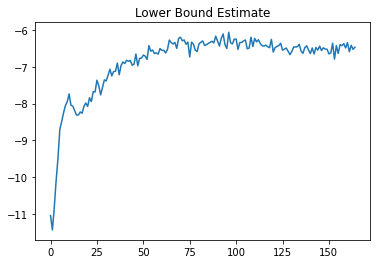

In [29]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

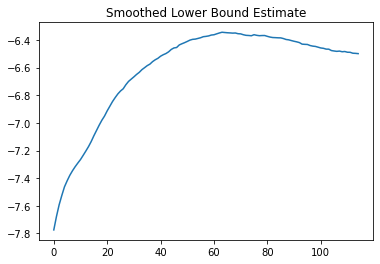

In [30]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [57]:
np.savetxt('vb_lb.txt', LB_estimate)

In [34]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.32856682,  0.18505138,  0.8180006 , -0.19400513])

Text(0.5, 1.0, 'Posterior density of alpha')

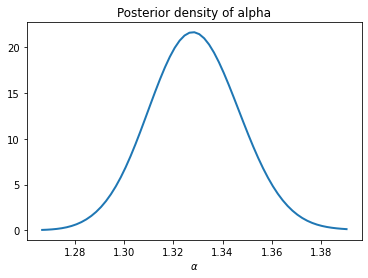

In [59]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

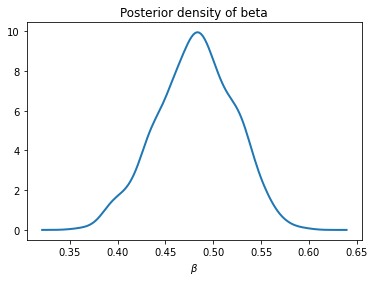

In [72]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

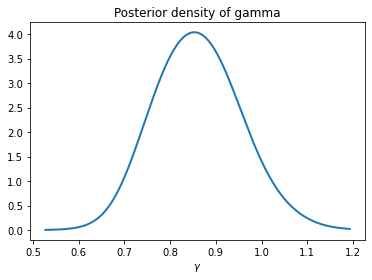

In [84]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

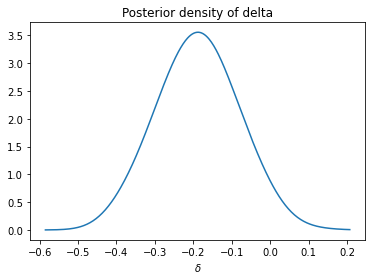

In [90]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_delta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=1.5)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

## RUN MCMC WITH ADAPTIVE RANDOM WALK

In [39]:
num_samples = 50000
num_burnin = 0.2 * num_samples

In [40]:
def sampler(samples):

	# ------------------- initialize MCMC

	w_size = num_coeffs  # num of weights and bias

	pos_w = np.ones((samples, w_size))  # posterior of all weights and bias over all samples
	pos_w_tilde = np.ones((samples, w_size))

	w_tilde = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
	# w_tilde = [np.log((actual_summary_statistics[0]-1.1)/(2-actual_summary_statistics[0])), np.log((1+actual_summary_statistics[1])/(1-actual_summary_statistics[1])), np.log(actual_summary_statistics[2]), actual_summary_statistics[3]]

	alpha = (2 * np.exp(w_tilde[0]) + 1.1) / (1 + np.exp(w_tilde[0]))
	beta = (np.exp(w_tilde[1]) - 1) / (np.exp(w_tilde[1]) + 1)
	gamma = np.exp(w_tilde[2])
	delta = w_tilde[3]
	w = np.array([alpha, beta, gamma, delta])

	# GENERATE GAMMA
	Gamma_init = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
	adjusted_w = np.concatenate((np.tile(w, (gamma_samples, 1)), Gamma_init), axis = 1)
	# --------------------- 

	prior_current = prior(w_tilde)  # takes care of the gradients

	likelihood_current = variance_adjustment_unbiased_log_likelihood(adjusted_w)

	naccept = 0
		
	for i in range(samples - 1):
		if i < 2000:
			w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
		else:
			if i % 500 == 0:
				Sign = np.cov(pos_w_tilde[0:i, :].T)
			u_proposal = random.uniform(0, 1)
			if u_proposal < 0.05:
				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
			else:
				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = (2.38**2/w_size) * Sign)

		alpha_prop = (2 * np.exp(w_proposal_tilde[0]) + 1.1) / (1 + np.exp(w_proposal_tilde[0]))
		beta_prop = (np.exp(w_proposal_tilde[1]) - 1) / (np.exp(w_proposal_tilde[1]) + 1)
		gamma_prop = np.exp(w_proposal_tilde[2])
		delta_prop = w_proposal_tilde[3]
		w_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

		# GENERATE GAMMA
		Gamma = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
		adjusted_w_proposal = np.concatenate((np.tile(w_proposal, (gamma_samples, 1)), Gamma), axis = 1)
		# --------------------- 

		prior_proposal = prior(w_proposal_tilde)  # takes care of the gradients
		likelihood_proposal = variance_adjustment_unbiased_log_likelihood(adjusted_w_proposal)

		diff_prior = prior_proposal - prior_current

		diff_likelihood = likelihood_proposal - likelihood_current

		try:
			mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

		except OverflowError as e:
			mh_prob = 1


		u = random.uniform(0, 1)

		if u < mh_prob:
			# Update position 
			naccept += 1
			likelihood_current = likelihood_proposal
			prior_current = prior_proposal
			w_tilde = w_proposal_tilde
			w = w_proposal
			pos_w_tilde[i + 1,] = w_proposal_tilde	
			pos_w[i + 1,] = w_proposal
			print(i, pos_w[i + 1,])

		else:
			pos_w_tilde[i + 1,] = pos_w_tilde[i,]
			pos_w[i + 1,] = pos_w[i,]

	print(naccept, ' num accepted')
	print(naccept / (samples * 1.0) * 100, '% was accepted')
	accept_ratio = naccept / (samples * 1.0) * 100

	return (pos_w, pos_w_tilde, accept_ratio)

In [41]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

0 [ 1.49457093  0.49823111  0.9844909  -0.00425812]
2 [ 1.47761606  0.50454627  0.96307602 -0.01746167]
4 [ 1.48549406  0.49187352  0.9421843  -0.03183523]
5 [ 1.46774803  0.52261021  0.95680244 -0.03271894]
6 [ 1.45814491  0.56667861  0.90952636 -0.09840693]
7 [ 1.44461596  0.55840482  0.86528959 -0.12090713]
8 [ 1.4487167   0.5514665   0.92775576 -0.18156806]
9 [ 1.44490681  0.54782195  0.93869231 -0.15549517]
10 [ 1.43063808  0.55342863  0.87666109 -0.07732394]
11 [ 1.45176989  0.55909771  0.90932279 -0.12118083]
12 [ 1.44818037  0.55236383  0.91468715 -0.21907322]
13 [ 1.44288216  0.52599583  0.94184057 -0.26968362]
14 [ 1.43821775  0.51921487  0.93860702 -0.26862867]
15 [ 1.4367274   0.51574115  0.8687391  -0.28366158]
16 [ 1.4383762   0.51656822  0.80338959 -0.27395798]
17 [ 1.42838584  0.48660502  0.7521234  -0.29546275]
18 [ 1.43226144  0.4883951   0.79660544 -0.35066221]
19 [ 1.42236191  0.4891614   0.79718036 -0.41836363]
20 [ 1.42612685  0.49832506  0.82174752 -0.41159229]
2

In [42]:
np.savetxt('mcmc_w_varobust.txt', pos_w)
np.savetxt('mcmc_w_tilde_varobust.txt', pos_w_tilde)

In [44]:
pos_w = np.loadtxt('mcmc_w_varobust.txt')
pos_w_tilde = np.loadtxt('mcmc_w_tilde_varobust.txt')

Text(0.5, 1.0, 'Posterior density of alpha')

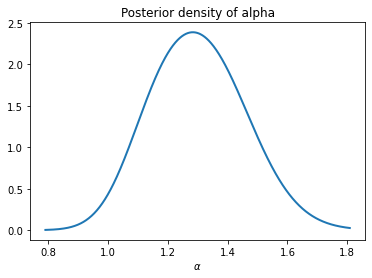

In [45]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
x_plot = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [46]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-4*pos_alpha_std,np.mean(best_alpha)-4*np.std(best_alpha)), max(pos_alpha_mean+4*pos_alpha_std, np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.15, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0)
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0)

plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


NameError: name 'best_alpha' is not defined

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Posterior density of beta')

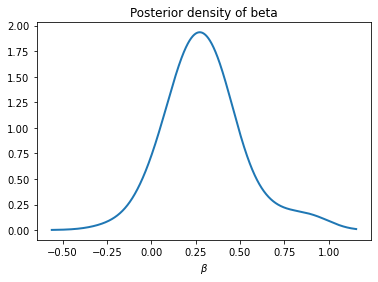

In [118]:
plt.figure()

pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
x_plot = np.arange((pos_beta_mean-4*pos_beta_std), (pos_beta_mean+4*pos_beta_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of beta')

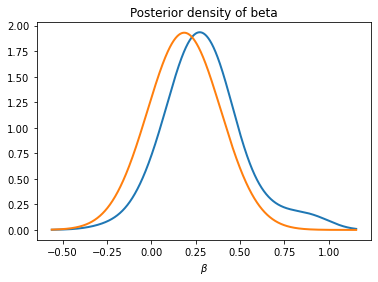

In [56]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0)
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0)

plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


Text(0.5, 1.0, 'Posterior density of gamma')

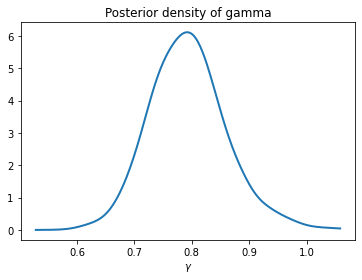

In [123]:
plt.figure()

pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
x_plot = np.arange((pos_gamma_mean-4*pos_gamma_std), (pos_gamma_mean+4*pos_gamma_std), 0.002)
kde = KernelDensity(bandwidth=0.02, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of gamma')

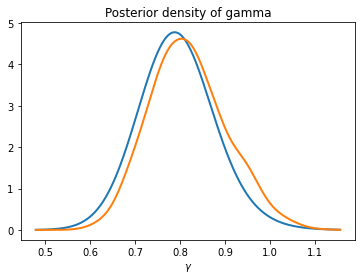

In [53]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-4*pos_gamma_std,np.mean(best_gamma)-4*np.std(best_gamma)), max(pos_gamma_mean+4*pos_gamma_std, np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.055, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.025, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0)
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0)

plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')


Text(0.5, 1.0, 'Posterior density of delta')

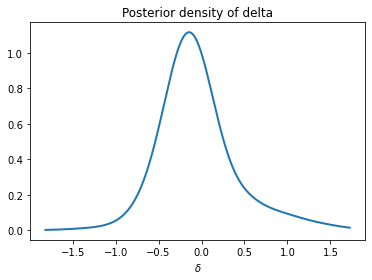

In [127]:
plt.figure()

pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
x_plot = np.arange((pos_delta_mean-4*pos_delta_std), (pos_delta_mean+4*pos_delta_std), 0.002)
kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

Text(0.5, 1.0, 'Posterior density of delta')

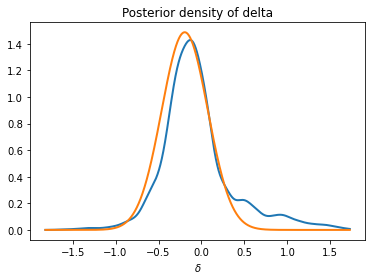

In [54]:
plt.figure()
pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_delta_mean-4*pos_delta_std,np.mean(best_delta)-4*np.std(best_delta)), max(pos_delta_mean+4*pos_delta_std, np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.07, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0)
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0)

plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')


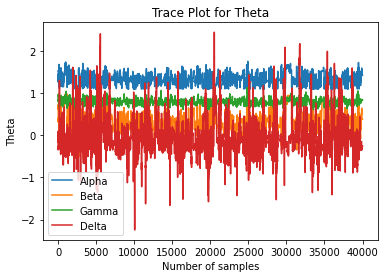

In [119]:
alpha_trace = pos_w[int(num_burnin):,0]
beta_trace = pos_w[int(num_burnin):,1]
gamma_trace = pos_w[int(num_burnin):,2]
delta_trace = pos_w[int(num_burnin):,3]

x = np.arange(len(alpha_trace))
plt.figure(facecolor = 'white')
plt.plot(x, alpha_trace, label='Alpha')  
plt.plot(x, beta_trace, label='Beta')  
plt.plot(x, gamma_trace, label='Gamma')  
plt.plot(x, delta_trace, label='Delta')  
plt.xlabel('Number of samples')
plt.ylabel('Theta')
plt.legend()
plt.title("Trace Plot for Theta")
plt.show()